In [1]:
import os
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image,draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
%matplotlib inline

Using TensorFlow backend.


In [28]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold= 0.6):
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores, -1)
    box_class_scores = K.max(box_scores, -1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes= tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

In [5]:
#intersection over union
def iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = max(box1[2], box2[2])
    yi2 = max(box1[3], box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3] - box1[1])* (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1])* (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area/union_area
    return iou

In [8]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    #tensor used in tf.image.non_max_suppression()of size 'max_boxes' 
    max_boxes_tensor = K.variable(max_boxes, dtype = 'int32')
    #initiating the tensor 
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    #Using the tensorflow function tf.image.non_max_suppression to get the indices of boxes kept
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    #Using K.gather to individually access scores, boxes and classes from nms_indices
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [19]:
yolo_outputs = (tf.random_normal([19,19,5,1], mean = 1, stddev = 4, seed = 1),
                tf.random_normal([19,19,5,2], mean = 1, stddev = 4, seed = 1),
                tf.random_normal([19,19,5,2], mean = 1, stddev = 4, seed = 1),
                tf.random_normal([19,19,5,80], mean = 1, stddev = 4, seed = 1))

In [22]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes = 10, score_threshold = .6, iou_threshold = .5):
  
    #Retrieving output
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    #Converting the boxes for filtering functions
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    #Using the function defined before to remove boxes with less confidence score
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    #Scaling the boxes
    boxes = scale_boxes(boxes, image_shape)
    #Using the function defined before for non-max suppression
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes


In [29]:
scores,boxes,classes = yolo_eval(yolo_outputs)

In [30]:
with tf.Session() as test_b:
    print('scores[2] = ' + str(scores[2].eval()))
    print('boxes[2] = ' + str(boxes[2].eval()))
    print('classes[2] = ' + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


In [32]:
sess =K.get_session()
class_names = read_classes('model_data/coco_classes.txt')
anchors = read_anchors('model_data/yolo_anchors.txt')
yolo_model =load_model('model_data/yolo.h5')


In [33]:
#Converting the output of model into usable bounding box tensors
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))


In [65]:
def predict(sess, image_file):
    #Preprocessing the image
    image, image_data = preprocess_image("images/"+image_file, model_image_size = (608,608))
    #Running the session and feeding the input to it
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict = {yolo_model.input: image_data, K.learning_phase(): 0})
    #Prints the predicted information
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    #Generates color for drawing bounding boxes
    colors = generate_colors(class_names)
    #Draws bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    #Saving the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality = 150)
    #Displaying the results in notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    plt.figure(figsize=(12,12))
    imshow(output_image)
    return out_scores, out_boxes, out_classes

In [75]:

#Loading the image
img = plt.imread('images/wp3121304.jpg')
#Calculating the size of image and passing it as a parameter to yolo_eval
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)


Found 4 boxes for wp3121304.jpg
dog 0.61 (402, 499) (949, 836)
dog 0.69 (53, 295) (647, 698)
cat 0.78 (13, 493) (529, 886)
cat 0.78 (567, 314) (1162, 770)


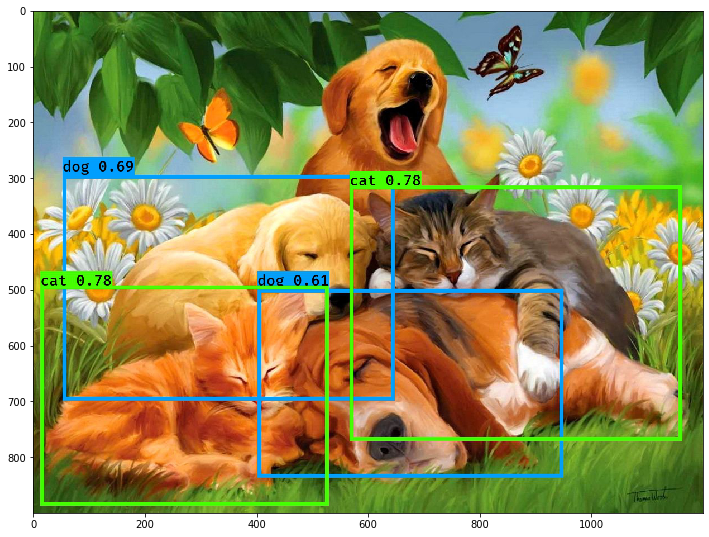

In [76]:
out_scores, out_boxes, out_classes = predict(sess, "wp3121304.jpg")